In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
plt.style.use("classic")
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20, 3)

In [2]:
path = "https://github.com/queiyanglim/oil_spread/blob/master/brent_wti.xlsx?raw=true"
# Trade Close. 1D = 1 day, 60M = 1 hour, 30M = 30 Minutes
df_raw = pd.read_excel(path, sheet_name="1D")

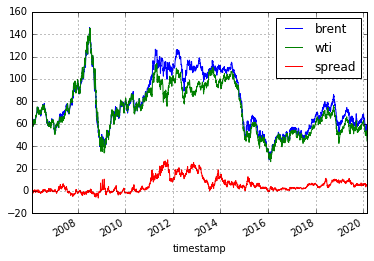

In [3]:
df = df_raw.copy()
df = df.iloc[6:]
df.columns = ["timestamp", "brent", "wti"]
df = df.set_index("timestamp")
df = df[df > 10] # filter erroneous data with less than $10/bbl
df = df.dropna()
df["spread"] = df.brent - df.wti
df.plot(grid = True)

## **Spread Modelling**
Model Brent's price as $P_{brent} = \alpha P_{wti} + \beta$

Tradeable spread: $P_{brent} - P_{wti}  = (\alpha - 1)P_{wti} + \beta$


Rolling regression

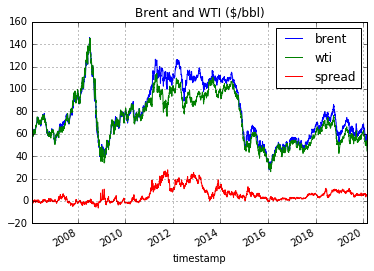

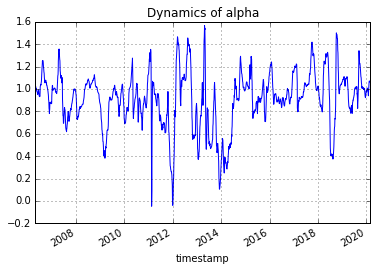

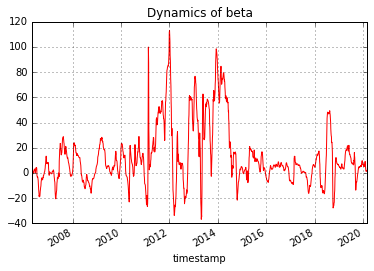

In [5]:
# Update with frequency
update_window = 60

alpha_list, beta_list = [], []

for i in range(update_window, len(df)):
    s = df.iloc[i-update_window+1:i+1]

    lin_reg = LinearRegression()
    X = s.wti.values.reshape(-1,1)
    y = s.brent.values
    lin_reg.fit(X, y)
    alpha, beta = lin_reg.coef_, lin_reg.intercept_
    
    alpha_list.append(float(alpha))
    beta_list.append(float(beta))

df.plot(grid= True, title = "Brent and WTI ($/bbl)")
plt.show()

period_coef = df.copy()[update_window:]
period_coef["alpha"]= alpha_list
period_coef["beta"] = beta_list

period_coef.alpha.plot(grid=True, title = "Dynamics of alpha")
plt.show()

period_coef.beta.plot(grid=True, title = "Dynamics of beta", color = "red")
plt.show()

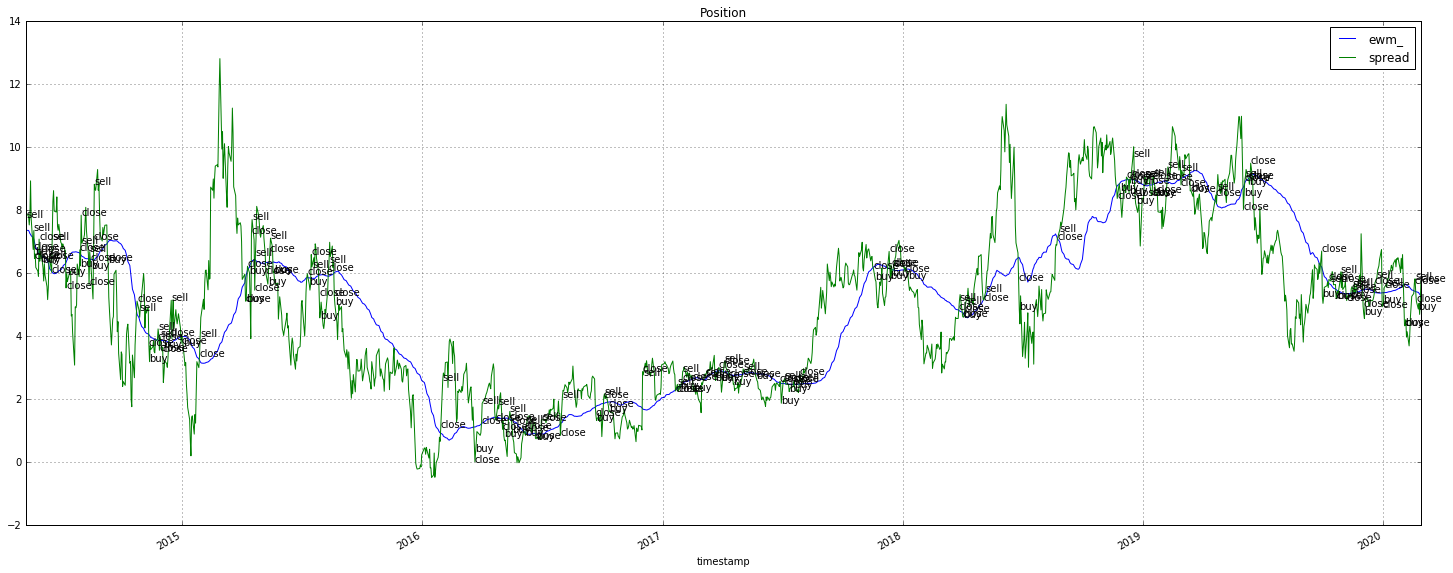

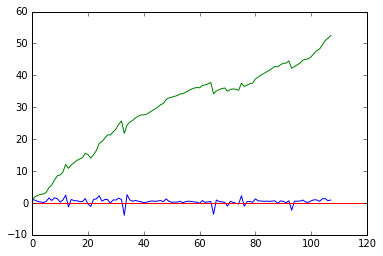

In [6]:
# MAIN PARAMETERS
ewm_span = 30
lookback_period = 1500 # Lookback whole period if == 0
buy_sell_tolerance = 0.1
initial_capital = 100000


period_coef.index.rename("timestamp", inplace=True)
fair_spread = (period_coef.alpha - 1) * period_coef.wti + period_coef.beta
fair_spread = pd.DataFrame(fair_spread.rename("fair_spread", inplace = True))

df_spread = pd.concat([fair_spread, df], axis = 1)
# df_spread = pd.concat([fair_spread, df.spread], axis = 1).reset_index()
# df_spread = df_spread.drop("timestamp", axis = 1)
df_spread["ewm_"] = df_spread.fair_spread.ewm(span = ewm_span).mean()

# Simple Moving Average
#df_spread["ewm_"] = df_spread.fair_spread.rolling(window = ewm_span).mean()

# Backtesting Period and EWM window
if lookback_period != 0: df_spread = df_spread.iloc[-lookback_period:]

# Plot entry and exit
ax = df_spread[["ewm_", "spread"]].plot(grid= True, figsize = (25,10), style = "-", title = "Position")

# 0: Flat, 1: long, -1: short
position = 0
prices = []


ret = []
style = dict(size=15, color='gray')

trade_details = []
def update_trade_details(spread_data, position):
    global trade_details
    trade_details.append({"timestamp": spread_data.name,
                        "position": position,
                        "brent_price": spread_data.brent,
                        "wti_price": spread_data.wti,
                        "signal": spread_data.ewm_})
    

for i, spread_data in df_spread.iterrows():    
    # Spread is too expensive, sell spread
    if spread_data.spread != 0:
        
        # Open position 
        if position == 0:
            open_price = spread_data.spread
            # Sell spread when spread is overpriced
            if spread_data.spread > spread_data.ewm_ + buy_sell_tolerance:
                ax.text(i,spread_data.spread, "sell")
                position = -1
                update_trade_details(spread_data, position)

            # Buy spread when spread it underpriced
            elif spread_data.spread < spread_data.ewm_ - buy_sell_tolerance:
                ax.text(i, spread_data.spread, "buy")
                position = 1
                update_trade_details(spread_data, position)

        # Check condition and close position
        if position !=0:
            close_price = spread_data.spread
            if position == -1 and spread_data.spread <= spread_data.ewm_:
                position = 0
                ax.text(i,spread_data.spread, "close")
                ret.append(-(close_price-open_price))
                update_trade_details(spread_data, position)
                
            elif position == 1 and spread_data.spread >= spread_data.ewm_:
                position = 0
                ax.text(i,spread_data.spread, "close")
                ret.append(close_price-open_price)
                update_trade_details(spread_data, position)
    
plt.show()

plt.plot(ret)
plt.plot(np.cumsum(ret))
plt.axhline(0,color="red")
plt.show()

Trade details

In [7]:
df_spread

fair_spread   brent     wti spread      ewm_
timestamp                                              
2014-05-08     7.49939  108.04  100.26   7.78  7.352038
2014-05-09     7.62043  107.89   99.99    7.9  7.369353
2014-05-12      7.3034  108.41  100.59   7.82  7.365098
2014-05-13     6.75042  109.24   101.7   7.54  7.325442
2014-05-14     6.41603  110.19  102.37   7.82  7.266770
...                ...     ...     ...    ...       ...
2020-02-24     5.15198    56.3   51.43   4.87  5.399122
2020-02-25     5.00184   54.95    49.9   5.05  5.373490
2020-02-26      4.9143   53.43   48.73    4.7  5.343865
2020-02-27      4.8368   52.18   47.09   5.09  5.311152
2020-02-28     4.79663   50.52   44.76   5.76  5.277957

[1500 rows x 5 columns]

In [ ]:
trade_log = pd.DataFrame(trade_details).set_index("timestamp")

trade_log["alpha"] = period_coef.loc[trade_log.index].alpha
trade_log["beta"] = period_coef.loc[trade_log.index].beta
trade_log
# trade_log.to_csv

position  brent_price  wti_price    signal     alpha       beta
timestamp                                                                  
2014-05-08        -1       108.04     100.26  7.352038  0.497379  57.892174
2014-05-19         0       109.37     102.61  7.138194  0.487529  58.854912
2014-05-20        -1       109.69     102.33  7.090029  0.478174  59.790074
2014-05-21         0       110.55     104.07  6.988610  0.490651  58.526023
2014-05-22         1       110.36     103.74  6.906117  0.498524  57.733139
...              ...          ...        ...       ...       ...        ...
2020-02-18         0        57.75      52.05  5.440188  1.068110   1.650139
2020-02-19        -1        59.12      53.29  5.430884  1.065987   1.779518
2020-02-21         0        58.50      53.38  5.416166  1.065508   1.795913
2020-02-24         1        56.30      51.43  5.399122  1.067029   1.704691
2020-02-28         0        50.52      44.76  5.277957  1.061059   2.063647

[216 rows x 6 columns]